In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from scipy import signal
from scipy import stats
from scipy import optimize, interpolate
import statistics

plt.rcParams['pdf.fonttype'] = 42


In [2]:
dirs = sorted(glob.glob("./dir_HS*"))
df_tot_CDK = pd.DataFrame()     # 分裂から分裂までの時系列データを格納
strains = []
for dir_name in dirs:
    data_plot = pd.DataFrame({})
    data_plot_line = pd.DataFrame({})

    strain_name = dir_name[6:]
    strains.append(strain_name)

    # 各strainのデータを読み込む
    data_all = pd.read_csv(dir_name + "/_results_40cells_aligned_by_nuc-div.csv")
    lineage_org = data_all[" Lineage"].unique().tolist()  # 元データのLineage列に含まれる文字列： [ a_..._z ]を重複なく抜き出す

    # 個別のlineageとして全データをレトリーブする
    for cmp in lineage_org:
        df_FRET = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C0"]
        df_CFP = data_all.loc[data_all[" Lineage"] == cmp, " AverageBrightness(Seg)_C1"]
        df_ratio = df_FRET / df_CFP
        ratio = df_ratio.values.tolist()
        smt_ratio = np.convolve(ratio, [1, 1, 1], mode="same")/3
        smt_ratio[0] = smt_ratio[1]
        smt_ratio[-1] = smt_ratio[-2]
        elt = [(i-len(ratio)+6)*5 for i in range(len(ratio))]
        elt_smt = [(i-len(smt_ratio)+6)*5 for i in range(len(smt_ratio))]
        peaks, _ = signal.find_peaks(ratio, height=1.8, distance=10)
        linID = [cmp[2:-2] for i in range(len(ratio))]
        strain = [strain_name for i in range(len(ratio))]
        
        temp = pd.DataFrame([elt, elt_smt, ratio, smt_ratio, linID, strain], index=["time", "smt-time", "ratio", "smt-ratio", "id", "strain"])
        df_tot_CDK = pd.concat([df_tot_CDK, temp.T], ignore_index=True)
df_tot_CDK.to_csv("./_data_all-aligned-by-nuc-div.csv")
print(df_tot_CDK)


      time smt-time     ratio smt-ratio  id strain
0     -145     -145  1.461491   1.51634   1  HS001
1     -140     -140  1.516785   1.51634   1  HS001
2     -135     -135  1.570744  1.546763   1  HS001
3     -130     -130   1.55276   1.55563   1  HS001
4     -125     -125  1.543385  1.539253   1  HS001
...    ...      ...       ...       ...  ..    ...
5792     5        5  1.499227  1.506498  40  HS189
5793    10       10  1.541336  1.525351  40  HS189
5794    15       15  1.535489  1.547445  40  HS189
5795    20       20  1.565509  1.564295  40  HS189
5796    25       25  1.591886  1.564295  40  HS189

[5797 rows x 6 columns]


In [5]:
def detect_min_frame(vs):
    diffs = []
    for i in range(len(vs) - 1):
        diffs.append(vs[i+1] - vs[i])
    min_frame = np.argmin(diffs)   # 傾きが一番小さいところ（落ちる直前）
    return min_frame, diffs

def change_point_detection_max_slope(ts, ratios, w=4):
    n_time = len(ts)
    diffs = np.zeros((n_time,))
    for i in range(n_time - w):
        beta, _ = np.polyfit(ts[i:i+w], ratios[i:i+w], deg=1)
        diffs[i] = beta
    frame_change = np.argmax(diffs)
    max_dif = max(diffs)
    med = statistics.median(diffs)
    frame_change2 = np.where(diffs > (med+max_dif)/2)[0][0]
    return frame_change, frame_change2, diffs


#
# piecewise linear regression
#
def piecewise_linear_two_segments(x, x0, y0, b0, b1):
    return np.piecewise(x, [x <= x0, x > x0], [lambda x: b0*(x - x0) + y0, lambda x: b1*(x - x0) + y0])

def piecewise_linear_three_segments(x, x0, x1, y0, b0, b1, b2):
    return np.piecewise(x, [x <= x0, np.logical_and(x0 < x, x <= x0 + x1), x0 + x1 < x], [lambda x: b0*(x - x0) + y0, lambda x: b1*(x-x0) + y0, lambda x: b2*(x - x0 - x1) + b1*(x - x0) + y0])

def initial_guess2(ts):
    rmin = 1.3
    rmax = 2.2
    tmin = ts[0]
    tmax = ts[-1]
    #p0_2 = [0.5*tmin, 1.6, 0., 0.]
    #bounds2 = ([tmin, rmin, 0.0, 0.0], [0, rmax, 0.1, 0.1])
    p0_2 = [0.5*(tmin + tmax), 1.6, 0., 0.]
    bounds2 = ([tmin, rmin, 0.0, 0.0], [tmax, rmax, 0.1, 0.1])
    return p0_2, bounds2

def initial_guess3(ts, p2):
    rmin = 1.3
    rmax = 2.2
    tmin = ts[0]
    tmax = ts[-1]
    p0_3 = [p2[0], 10, p2[1], p2[2], p2[2], p2[3]]
    bounds3 = ([tmin, 0, rmin, 0.0, 0.0, 0.0], [tmax, 200, rmax, 0.1, 0.1, 0.1])
    return p0_3, bounds3



ratio_drops = []
ratio_peaks = []
ratio_cps = []
cells_plt = []
strains_plt = []
ratio_cps_value = []
ratio_peaks_value = []
ratio_cyclin_value = []
for strain in strains:
    df_strain = df_tot_CDK.loc[df_tot_CDK["strain"]==strain]
    cells = df_strain['id'].unique().tolist()
    cells_to_omit = omit_dict[strain]

    CDK_peaks = []
    cell_ids = []
    n_cells = len(cells)
    print('strain: ', strain, ', # of cells: ', n_cells)
    
    change_points_max_slope = np.zeros((n_cells,))

    for cell in cells:
        if int(cell) in cells_to_omit:
            continue

        df = df_strain.loc[df_strain["id"] == cell]
        ts = df["time"].astype(float).tolist()
        rs = df["smt-ratio"].tolist()

        min_frame_ratio, _ = detect_min_frame(rs)
        peak_frame_ratio = np.argmax(rs)

        w1 = 5
        w2 = peak_frame_ratio
        p0_twoseg, bounds_twoseg = initial_guess2(ts[w1:w2])
        p2, _ = optimize.curve_fit(piecewise_linear_two_segments, ts[w1:w2], rs[w1:w2], p0=p0_twoseg, bounds=bounds_twoseg)
        p0_threeseg, bounds_threeseg = initial_guess3(ts[w1:w2], p2)
        p3, _ = optimize.curve_fit(piecewise_linear_three_segments, ts[w1:w2], rs[w1:w2], p0=p0_threeseg, bounds=bounds_threeseg)
        
        ratio_drops.append(ts[min_frame_ratio])
        ratio_peaks.append(ts[peak_frame_ratio])
        cells_plt.append(cell)
        strains_plt.append(strain)
        ratio_cyclin_value.append(df.loc[df["time"]==-30]["smt-ratio"].values[0])
        ratio_peaks_value.append(rs[peak_frame_ratio])
        if strain == "HS115":
            ratio_cps.append(p3[0] + p3[1])
            ratio_cps_value.append(float(piecewise_linear_three_segments(p3[0] + p3[1], *p3)))
        else:
            ratio_cps.append(p2[0])
            ratio_cps_value.append(float(piecewise_linear_two_segments(p2[0], *p2)))
            
df_time_plot = pd.DataFrame({})
df_time_plot["ratio_drop"] = ratio_drops
df_time_plot["ratio_peak"] = ratio_peaks
df_time_plot["ratio_cp"] = ratio_cps
df_time_plot["cell"] = cells_plt
df_time_plot["strain"] = strains_plt

df_CDK_plot = pd.DataFrame({})
df_CDK_plot["CDKatCP"] = ratio_cps_value
df_CDK_plot["CDKatCyc"] = ratio_cyclin_value
df_CDK_plot["CDKatPeak"] = ratio_peaks_value
df_CDK_plot["cell"] = cells_plt
df_CDK_plot["strain"] = strains_plt


strain:  HS001 , # of cells:  40
strain:  HS115 , # of cells:  40
strain:  HS189 , # of cells:  40


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


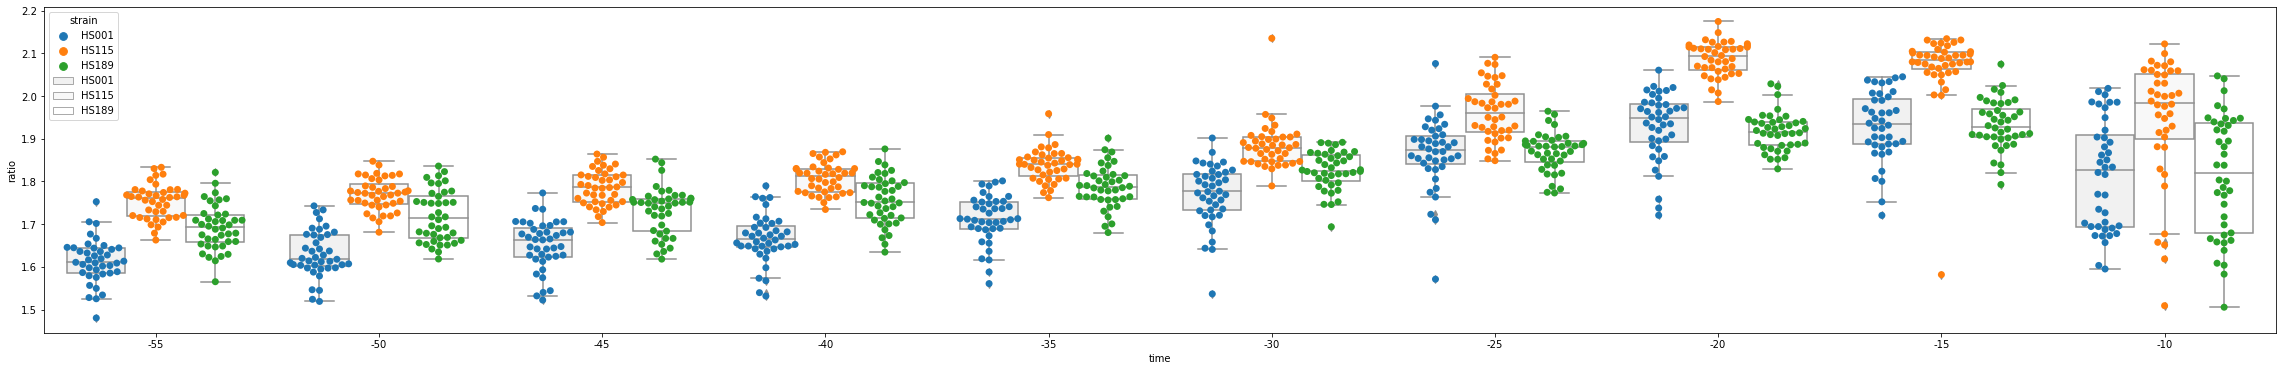

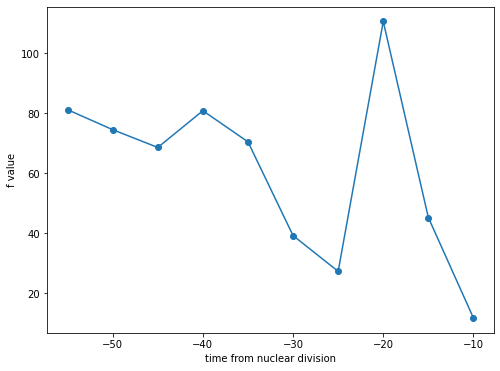

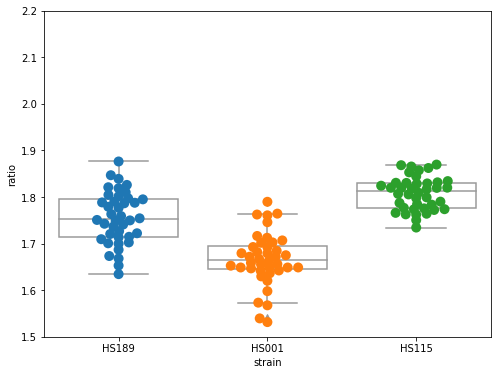

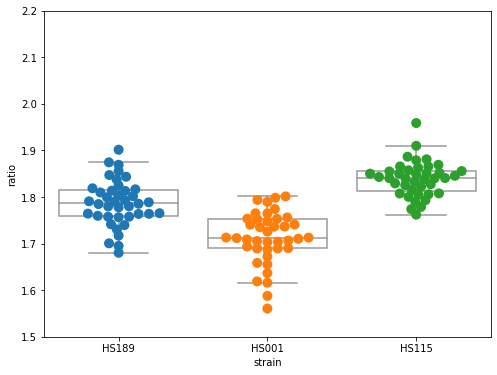

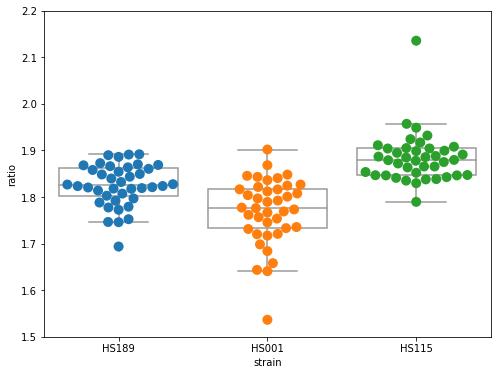

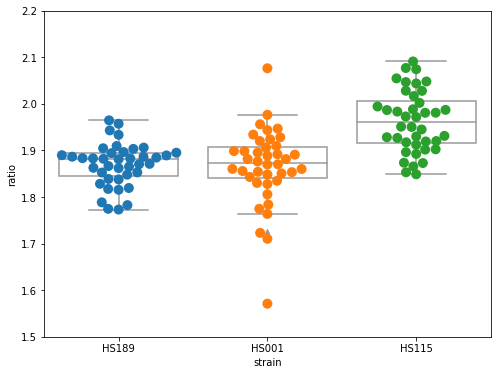

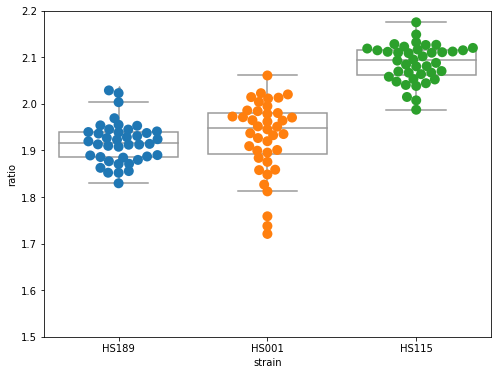

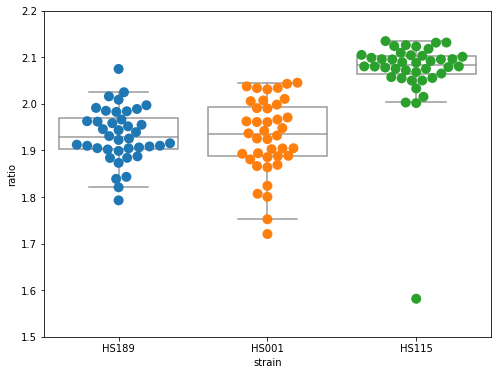

In [14]:
df = df_tot_CDK.loc[(df_tot_CDK["time"]>-60) & (df_tot_CDK["time"]<-5)]
fig = plt.figure(figsize=(40, 6))
sns.swarmplot(x="time", y="ratio", data=df, hue="strain", dodge=True, s=7)
sns.boxplot(x="time", y="ratio", data=df, hue="strain", color="white")
plt.savefig("./CDKactivities-time.png")
plt.savefig("./CDKactivities-time.pdf")

frames = df["time"].unique().tolist()
fig = plt.figure(figsize=(8, 6))
ts = []
fs = []
for frame in frames:
    df_A = df.loc[(df["time"]==frame) & (df["strain"]=="HS189")]["ratio"]
    df_B = df.loc[(df["time"]==frame) & (df["strain"]=="HS001")]["ratio"]
    df_C = df.loc[(df["time"]==frame) & (df["strain"]=="HS115")]["ratio"]
    fvalue, pvalue = stats.f_oneway(df_C, df_A, df_B)
    ts.append(frame)
    fs.append(fvalue)
plt.plot(ts, fs, marker="o")
plt.xlabel("time from nuclear division")
plt.ylabel("f value")
plt.savefig("./fvalues-time.png")
plt.savefig("./fvalues-time.pdf")
order = ["HS189", "HS001", "HS115"]
for frame in frames:
    if not frame in [-40, -35, -30, -25, -20, -15]:
        continue
    df2 = df.loc[(df["time"]==frame)]
    fig = plt.figure(figsize=(8, 6))
    sns.swarmplot(x="strain", y="ratio", data=df2, order=order, s=10)
    sns.boxplot(x="strain", y="ratio", data=df2, order=order, color="white")
    plt.ylim([1.5, 2.2])
    plt.savefig("./_CDKactivity_at_" + str(frame)[1:] + "min.png")
    plt.savefig("./_CDKactivity_at_" + str(frame)[1:] + "min.pdf")
